## Imports

In [67]:
import pandas as pd
import numpy as np
import cvxpy as cp

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras import saving
#Tensor Flow
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras import backend as K
import time

## Constants

In [209]:
# portfolio cardinality
cardinality = 50

# training data size
n_training_portfolios = 500
# testing data size
n_testing_portfolios = 500


# ANN training epochs
EPOCH=50
# ANN training batch size
BATCH_SIZE=64

import os

## CVX Optimizer 

In [129]:
def max_portfolio_return(n, mu, Q, gamma = 1):
    '''
    Params
    n = total stocks in current portfolio plus the one stock selected by ANN
    mu = array of mu values in current portfolio plus the mu of selected stock

    Returns
    Max portfolio returns of new portfolio according mvo weights
    '''

    start_time = time.time()   
 
    # Create optimization variable for weights of stocks in portfolio
    w = cp.Variable(n)

    # Define Markowitz constraints
    constraints = [sum(w) == 1, w >= 0]
    # prob_max_returns = cp.Problem(cp.Maximize(mu.T@w), constraints)
    risk_weighted_returns = cp.Problem(cp.Maximize((gamma*mu.T@w) - cp.quad_form(w,cp.psd_wrap(Q))), constraints)

    end_time = time.time()

    running_time = end_time - start_time
                    
    # Solve the optimization
    return risk_weighted_returns.solve(verbose=False), running_time

## Portfolio Generator Functions

We can initialize portfolios randomly that are less than the cardinality constraint

In [54]:
# Initialize Training Portfolios
def gen_training_portoflios(df_train_mu, df_train_Q, n_training_portfolios):

    training_portfolios = []
    for n in range(n_training_portfolios):

        # Total stocks in training batch: (1 prediction stock + initial portfolio stocks)
        n_stocks = int(np.random.rand(1)[0]*cardinality + 1)
        
        # Select stocks from synthetic database to initialize prediction stock + portfolio
        stock_indices=np.random.choice((len(df_train_mu)-1), n_stocks, replace=False)

        # Store mu portfolio
        stock_mu = np.zeros(cardinality)
        for i, index_i in enumerate(stock_indices):
            stock_mu[i] = df_train_mu.loc[index_i]
        
        
        # Store Q portfolio
        stock_Q = np.zeros((cardinality, cardinality))
        for i,index_i in enumerate(stock_indices):
            for j,index_j in enumerate(stock_indices):
                stock_Q[i][j] = df_train_Q.iloc[index_i,index_j]

        temp_portfolio = [stock_mu,stock_Q]

        # build training portfolios
        training_portfolios.append(temp_portfolio)  

    return training_portfolios

# Initialize Testing Portfolios
def gen_testing_portfolios(df_test_mu, df_test_Q, n_testing_portfolios):

    testing_portfolios = []
    for n in range(n_testing_portfolios):

        # Total stocks in training batch: (1 prediction stock + initial portfolio stocks)
        n_stocks = int(np.random.rand(1)[0]*cardinality + 1)
        
        # Select stocks from synthetic database to initialize prediction stock + portfolio
        stock_indices=np.random.choice((len(df_test_mu)-1), n_stocks, replace=False)

        # Store mu portfolio
        stock_mu = np.zeros(cardinality)
        for i, index_i in enumerate(stock_indices):
            stock_mu[i] = df_test_mu.loc[index_i]
        
        
        # Store Q portfolio
        stock_Q = np.zeros((cardinality, cardinality))
        for i,index_i in enumerate(stock_indices):
            for j,index_j in enumerate(stock_indices):
                stock_Q[i][j] = df_test_Q.iloc[index_i,index_j]

        temp_portfolio = [stock_mu,stock_Q]

        # build training portfolios
        testing_portfolios.append(temp_portfolio) 

    return testing_portfolios

In [55]:
# Create Training Portfolios
training_portoflios = []
for day in os.listdir('Data\synthetic1000'):
    
     # Load mu Dataset
    df_train_mu = pd.read_csv(f'Data\synthetic1000\{day}\mu', header = None, names = ['mu'])
    # Load Q Dataset 
    df_train_Q=pd.read_fwf(f'Data\synthetic1000\{day}\Q', header = None)

    # Call Portfolio Generator
    training_portoflios_day = gen_training_portoflios(df_train_mu, df_train_Q, n_training_portfolios)

    # Store training portfolios
    training_portoflios.append(training_portoflios_day)

# Create Testing Portfolios
testing_portfolios = []
for day in os.listdir('Data\synthetic500'):
    
    # Load mu Dataset
    df_test_mu = pd.read_csv(f'Data\synthetic500\{day}\mu', header = None, names = ['mu'])
    # Load Q Dataset 
    df_test_Q=pd.read_fwf(f'Data\synthetic500\{day}\Q', header = None)

    # Call Portfolio Generator
    training_portoflios_day = gen_training_portoflios(df_test_mu, df_test_Q, n_testing_portfolios)
    # Store training portfolios
    testing_portfolios.append(training_portoflios_day)

C:\Users\stefa\AppData\Local\Temp\ipykernel_133436\1215528042.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_mu[i] = df_train_mu.loc[index_i]
C:\Users\stefa\AppData\Local\Temp\ipykernel_133436\1215528042.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_mu[i] = df_train_mu.loc[index_i]
C:\Users\stefa\AppData\Local\Temp\ipykernel_133436\1215528042.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_mu[i] = df_train_mu.loc[index_i]
C:\Users\stefa\AppData\Local\Temp\ipykernel_133436\1215528042.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_mu[i] = df_train_mu.l

## ANN

In [208]:
def get_ann_model(input_shape):    
    # Deep stacked MLP with dropout
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        # keras.layers.Flatten(input_shape=input_shape),
        # keras.layers.Dense(1024, kernel_initializer='normal', activation='relu',
        #                    kernel_regularizer= keras.regularizers.L1L2(l1=0.01, l2=0.01)),
        # keras.layers.Dense(512, kernel_initializer='normal', activation='relu'),
        # keras.layers.Dropout(0.1),
        keras.layers.Dense(256, kernel_initializer='normal', activation='relu',
                           kernel_regularizer= keras.regularizers.L1L2(l1=0.01, l2=0.01)),
        keras.layers.Dropout(0.1),
        # keras.layers.Dense(128,kernel_initializer='normal', activation='relu'),
        # keras.layers.Dense(64,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(32,kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, activation='relu'),
    ])
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError()],
    )
    return model

## Train ANN

Every unique initialized portfolio can be thought of as a separate problem to learn. In order for the ANN to have sufficient training exposure to learn the portolio combinations, we can train 10 different stocks for each 500 portfolios.


The maximum portfolio returns porblem is a regression problem. Given a randomly chosen stock, the ANN will take in the current portfolio mu vector, the covariance matrix, and the selected stock and try and predict the new maximum portfolio returns of the blended portfolio.

After training the ANN, we can loop through all the possible stocks, predict the new maximum portfolio returns of introducing that stock, and each iteration, select the highest performing stock until cardinality is reached.

In [168]:
# Get Training Targets
def get_training_targets(training_portoflios):
    
    # Initialize Lists
    train_targets=[]
    df_train =[]
    train_MVO_size = []
    train_running_time = []

    for day in range(len(training_portoflios)):
        
        # Initialize Lists
        day_train_targets = []
        day_df_train = []
        day_train_MVO_size = []
        day_train_runnning_time = []

        # Counter
        print(f'day {day} out of {len(training_portoflios)}')

        # Get 500 Portfolios in current day
        for portfolio in (training_portoflios[day]):

            #MVO problem size
            mvo_size = np.count_nonzero(portfolio[0])

            # MVO Input Parameters
            n = len(portfolio[0])
            mu_vector = portfolio[0]
            Q_array = portfolio[1]

            # Call Optimizer
            target, running_time = max_portfolio_return(n, mu_vector, Q_array, gamma = 1)

            # Linearize Training Data for ANN
            day_df_train.append(np.append(portfolio[0],portfolio[1].flatten()))

            # Store day data
            day_train_targets.append(target)
            day_train_MVO_size.append(mvo_size)
            day_train_runnning_time.append(running_time)
        
        # Store train data
        train_targets.append(day_train_targets)
        df_train.append(day_df_train)
        train_MVO_size.append(day_train_MVO_size)
        train_running_time.append(day_train_runnning_time)
    
    # Convert to array
    train_targets=np.array(train_targets)
    df_train=np.array(df_train)

    return train_targets, df_train, train_MVO_size, train_running_time

# Get Testing Targets
def get_testing_targets(testing_portoflios):
    
    test_targets=[]
    df_test = []
    test_MVO_size = []
    test_running_time = []

    for day in range(len(testing_portoflios)):
        
        # Initialize Lists
        day_test_targets = []
        day_df_test = []
        day_test_MVO_size = []
        day_test_runnning_time = []
        
        # Counter
        print(f'day {day} out of {len(testing_portoflios)}')

        # Get 500 Portfolios in current day
        for portfolio in (testing_portoflios[day]):

            #MVO problem size
            mvo_size = np.count_nonzero(portfolio[0])

            # MVO Input Parameters
            n = len(portfolio[0])
            mu_vector = portfolio[0]
            Q_array = portfolio[1]

            # Call Optimizer
            target, running_time = max_portfolio_return(n, mu_vector, Q_array, gamma = 1)

            # Linearize Testing Data for ANN
            day_df_test.append(np.append(portfolio[0],portfolio[1].flatten()))

            # Store day data
            day_test_targets.append(target)
            day_test_MVO_size.append(mvo_size)
            day_test_runnning_time.append(running_time)
        
        # Store train data
        test_targets.append(day_test_targets)
        df_test.append(day_df_test)
        test_MVO_size.append(day_test_MVO_size)
        test_running_time.append(day_test_runnning_time)

    # Convert to array
    test_targets=np.array(test_targets)
    df_test=np.array(df_test)

    return test_targets, df_test, test_MVO_size, test_running_time

In [169]:
train_targets, df_train, train_MVO_size, train_running_time = get_training_targets(training_portoflios)

day 0 out of 52
day 1 out of 52
day 2 out of 52
day 3 out of 52
day 4 out of 52
day 5 out of 52
day 6 out of 52
day 7 out of 52
day 8 out of 52
day 9 out of 52
day 10 out of 52
day 11 out of 52
day 12 out of 52
day 13 out of 52
day 14 out of 52
day 15 out of 52
day 16 out of 52
day 17 out of 52
day 18 out of 52
day 19 out of 52
day 20 out of 52
day 21 out of 52
day 22 out of 52
day 23 out of 52
day 24 out of 52
day 25 out of 52
day 26 out of 52
day 27 out of 52
day 28 out of 52
day 29 out of 52
day 30 out of 52
day 31 out of 52
day 32 out of 52
day 33 out of 52
day 34 out of 52
day 35 out of 52
day 36 out of 52
day 37 out of 52
day 38 out of 52
day 39 out of 52
day 40 out of 52
day 41 out of 52
day 42 out of 52
day 43 out of 52
day 44 out of 52
day 45 out of 52
day 46 out of 52
day 47 out of 52
day 48 out of 52
day 49 out of 52
day 50 out of 52
day 51 out of 52


In [214]:
np.mean(train_targets.flatten())

-0.3940770695545485

<Axes: >

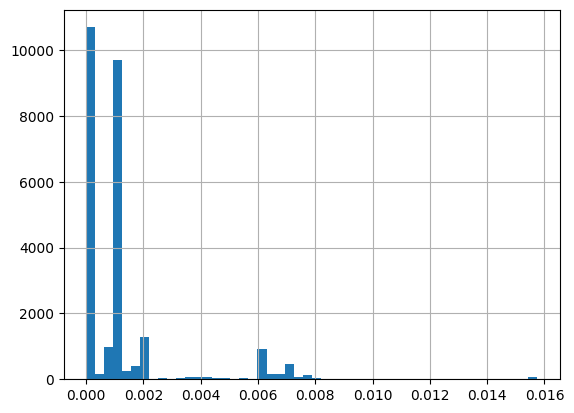

In [196]:
# Graph Runtimes

# Linearize MVO sizes and running times
run_times = np.array(train_running_time).flatten()
MVO_sizes = np.array(train_MVO_size).flatten()

# Create Pandas
df_cvx = pd.DataFrame(data = MVO_sizes, columns=['MVO_size'])
df_cvx['run_times'] = run_times

# Plot runtime distributions

df_cvx['run_times'].hist(bins=50)

In [210]:
# Train ANN
         
# Store Results
model_history=[]
model_predictions=[]


# Linearize Inputs and Targets
inputs = df_train.reshape(-1,df_train.shape[-1])
targets = train_targets.reshape(-1,1)

# Call Model
input_shape = inputs.shape[-1]
model_ANN = get_ann_model(input_shape)

print('-----Training RNN Model-----')
mlp_history = model_ANN.fit(inputs, targets,  
                            epochs=EPOCH, batch_size=BATCH_SIZE) 
                            #callbacks=[lr, es,mc_rnn])      # Can put callbacks in later

-----Training RNN Model-----
Epoch 1/50
407/407 [==============================] - 4s 9ms/step - loss: 77.9941 - root_mean_squared_error: 2.8016
Epoch 2/50
407/407 [==============================] - 3s 8ms/step - loss: 17.4706 - root_mean_squared_error: 2.7953
Epoch 3/50
407/407 [==============================] - 3s 8ms/step - loss: 10.0987 - root_mean_squared_error: 2.7953
Epoch 4/50
407/407 [==============================] - 3s 9ms/step - loss: 8.7315 - root_mean_squared_error: 2.7953
Epoch 5/50
407/407 [==============================] - 4s 9ms/step - loss: 8.5210 - root_mean_squared_error: 2.7953
Epoch 6/50
407/407 [==============================] - 4s 9ms/step - loss: 8.5228 - root_mean_squared_error: 2.7953
Epoch 7/50
407/407 [==============================] - 3s 9ms/step - loss: 8.5417 - root_mean_squared_error: 2.7953
Epoch 8/50
407/407 [==============================] - 4s 9ms/step - loss: 8.5566 - root_mean_squared_error: 2.7953
Epoch 9/50
407/407 [============================

## Create Optimal Portfolio

In [ ]:
# Load Data
day = '2016-01-03'

# Load mu Dataset
available_mu = pd.read_csv(f'Data\synthetic1000\{day}\mu', header = None, names = ['mu'])
# Load Q Dataset 
available_Q=pd.read_fwf(f'Data\synthetic1000\{day}\Q', header = None)

# For each available stock, run ANN on current portfolio + selected stock
# and calculate the risk-weighted returns
# Select the stock with the maximum risk-weighted returns




